Imported Libaries

In [1]:
import pandas as pd
import chardet
import os
pd.options.mode.chained_assignment = None
from sqlalchemy import create_engine, text, inspect
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display as original_display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import inspect
import re
import string
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Standard Functions

In [2]:
#Function to clean labels in any plot functions
def clean_label(label):
    return label.replace('_', ' ').title()
 
#Function for getting the name of a Dataframe
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
 
#Function to validate the data in a Dataframe
def validate_data(df, show_counts=False):
    df_name = get_var_name(df)
    print(f'#########################################################################################################################################################################################\nDataFrame: {df_name}')
    #snapshot the dataset
    display(df)
    #check for unique values
    unique_counts = pd.DataFrame(df.nunique())
    unique_counts = unique_counts.reset_index().rename(columns={0:'No. of Unique Values', 'index':'Field Name'})
    print("Unique values per field:")
    pd.set_option('display.max_rows', None)
    display(unique_counts)
    pd.reset_option('display.max_rows')
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count,'\n')
    info = df.info(show_counts=show_counts)
    display(info)
    #summary stats
    print("\nSummary statistics:")
    display(df.describe())
    print('End of data validation\n#########################################################################################################################################################################################\n')
 
#Function to provide list for data sources as a dataframe when conducting analysis
def header_list(df):
    df_list_ = df.copy()
    df_list = df_list_.columns.tolist()
    df_list = pd.DataFrame(df_list)
    new_header = df_list.iloc[0]  # Get the first row for the header
    df_list = df_list[1:]  # Take the data less the header row
    df_list.columns = new_header  # Set the header row as the df header
    df_list.reset_index(drop=True, inplace=True)  # Reset index
   
    return df_list
 
def query_data(schema, data):
    # Define the SQL query
    query = f'SELECT * FROM [{schema}].[{data}]'
 
    # Load data into DataFrame
    df = pd.read_sql(query, engine)
 
    print(f'Successfully imported {data}')
    # Display the DataFrame
    return df

def display(df):
    # Attempt to get the name of the DataFrame from the caller's local variables
    frame = inspect.currentframe().f_back
    # Attempt to find the variable name corresponding to the DataFrame
    name = "Unnamed DataFrame"
    for var_name, var_value in frame.f_locals.items():
        if var_value is df:
            name = var_name
            break
 
    # If the name is not in the list to be excluded, print it
    if name not in {'df', 'Unnamed DataFrame', 'unique_counts'}:
        print(f"DataFrame: {name}")
    # Always display the DataFrame regardless of the name
    original_display(df)

def unique_values(df, display_df=True):
    # Extract unique values for each field and store them in a dictionary
    unique_values = {col: df[col].unique() for col in df.columns}
    # Find the maximum number of unique values
    max_length = max(len(values) for values in unique_values.values())
    # Create a dictionary for the new DataFrame with padded None values
    unique_df_data = {}
    for col, values in unique_values.items():
        unique_df_data[col] = list(values) + [None] * (max_length - len(values))
    # Create the new DataFrame
    unique_df = pd.DataFrame(unique_df_data)
    if display_df == True:
        # Set display options to show all rows and display the DataFrame
        pd.set_option('display.max_rows', None)
        display(unique_df.head(100))
        # Reset display options back to default
        pd.reset_option('display.max_rows')

def export_to_csv(df):
    df_name = get_var_name(df)
    # Specify the directory and filename
    directory = r"C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Python CSV Repositry"
    file_path = f'{directory}\\{df_name}.csv'
    # Export the DataFrame to the specified directory
    df.to_csv(file_path, index=False)
    print(f'Successfully exported {df_name} to CSV')

Database and CWD setup and connection

In [3]:
# Database credentials
db_host = 'LBHHLWSQL0001.lbhf.gov.uk'
db_port = '1433'
db_name = 'IA_ODS'
 
# Create the connection string for SQL Server using pyodbc with Windows Authentication
connection_string = f'mssql+pyodbc://@{db_host}:{db_port}/{db_name}?driver=ODBC+Driver+17+for+SQL+Server&Trusted_Connection=yes'

# Create the database engine
engine = create_engine(connection_string)

files = os.listdir(os.getcwd())
print("Files in: %s" % (files))

Files in: ['BT Hex ID to Borough Lookup Table.csv', 'Footfall Script.ipynb', 'hex_3hourly_counts_2022.csv', 'hex_3hourly_counts_2023.csv', 'hex_3hourly_counts_2024.csv']


In [4]:
footfall_2022 = pd.read_csv('hex_3hourly_counts_2022.csv')
footfall_2023 = pd.read_csv('hex_3hourly_counts_2023.csv')
footfall_2024 = pd.read_csv('hex_3hourly_counts_2024.csv')
hex_to_borough = pd.read_csv('BT Hex ID to Borough Lookup Table.csv')

In [5]:
footfall_data_2022 = footfall_2022.copy()
footfall_data_2023 = footfall_2023.copy()
footfall_data_2024 = footfall_2024.copy()
hex_to_borough_data = hex_to_borough.copy()

footfall_data = pd.concat([footfall_data_2022,footfall_data_2023,footfall_data_2024])

footfall_data = pd.merge(footfall_data,hex_to_borough_data, left_on='hex_id', right_on='Hex_ID', how='left')
footfall_data = footfall_data[footfall_data['borough_name'] == 'H&F']

In [6]:
lbhf_footfall_data = footfall_data.copy()

lbhf_footfall_data = lbhf_footfall_data.drop(
    columns = [
        'Hex_ID','GSS_CODE','borough_name'
    ]
)

columns_to_convert = [
    'resident','visitor','worker'
]
lbhf_footfall_data.loc[:, columns_to_convert] = lbhf_footfall_data[columns_to_convert].applymap(lambda x: np.nan if x < 0 else x)
lbhf_footfall_data[columns_to_convert] = lbhf_footfall_data[columns_to_convert].fillna(0)
lbhf_footfall_data[columns_to_convert] = lbhf_footfall_data[columns_to_convert].astype('uint16')

columns_to_convert = [
    'day', 'time_indicator'
]
lbhf_footfall_data['day'] = lbhf_footfall_data['day'].astype('category')
lbhf_footfall_data['time_indicator'] = lbhf_footfall_data['time_indicator'].str.strip("'")
lbhf_footfall_data['count_date'] = pd.to_datetime(lbhf_footfall_data['count_date'])
lbhf_footfall_data['year'] = lbhf_footfall_data['count_date'].dt.year
lbhf_footfall_data['month'] = lbhf_footfall_data['count_date'].dt.month
lbhf_footfall_data['DoY'] = lbhf_footfall_data['count_date'].dt.day_of_year

lbhf_footfall_data[columns_to_convert] = lbhf_footfall_data[columns_to_convert].astype('category')

lbhf_footfall_data = lbhf_footfall_data.dropna(
    subset=[
        'dwell_time','resident','visitor','worker'
    ],
    how='all'
)

lbhf_footfall_data['total_footfall'] = lbhf_footfall_data['resident'] + lbhf_footfall_data['worker'] + lbhf_footfall_data['visitor']
lbhf_footfall_data

,hex_id,count_date,day,time_indicator,resident,visitor,worker,loyalty_percentage,dwell_time,year,month,DoY,total_footfall
5444971,11211233,2022-05-01,Sun,03-06,484,0,0,2.30,144.14,2022,5,121,484
5444972,11211233,2022-05-01,Sun,06-09,537,0,0,1.45,128.23,2022,5,121,537
5444973,11211233,2022-05-01,Sun,09-12,601,0,0,3.50,100.62,2022,5,121,601
5444974,11211233,2022-05-01,Sun,12-15,613,123,14,3.10,100.44,2022,5,121,750
5444975,11211233,2022-05-01,Sun,15-18,623,99,13,2.94,78.63,2022,5,121,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104471796,11381218,2024-10-13,Sun,09-12,31,0,0,13.04,98.52,2024,10,287,31
104471797,11381218,2024-10-13,Sun,12-15,24,0,0,16.78,89.17,2024,10,287,24
104471798,11381218,2024-10-13,Sun,15-18,33,0,0,10.50,87.14,2024,10,287,33
104471799,11381218,2024-10-13,Sun,18-21,17,0,0,18.02,94.02,2024,10,287,17


In [11]:
agg_data = lbhf_footfall_data.groupby(['hex_id','month','year','time_indicator']).agg(
    total_footfall = ('total_footfall','sum'),
    residents_sum = ('resident','sum'),
    workers_sum = ('worker','sum'),
    visitors_sum = ('visitor','sum'),
    average_footfall = ('total_footfall','mean'),
    residents_mean = ('resident','mean'),
    workers_mean = ('worker','mean'),
    visitors_mean = ('visitor','mean'),
    loyalty = ('loyalty_percentage','mean'),
    dwell_time = ('dwell_time','mean')
)
agg_data = agg_data.reset_index()
agg_data = agg_data.sort_values(
    ['year','total_footfall', 'hex_id'],
    ascending=False
)

columns_to_convert = [
    'residents_sum','workers_sum','visitors_sum'
]
agg_data['residents_sum'] = agg_data['residents_sum']/agg_data['total_footfall']
agg_data['workers_sum'] = agg_data['workers_sum']/agg_data['total_footfall']
agg_data['visitors_sum'] = agg_data['visitors_sum']/agg_data['total_footfall']
#agg_data[columns_to_convert] = agg_data[columns_to_convert].astype(per)

agg_data_2024 = agg_data[agg_data['year'] == 2024]
agg_data_2023 = agg_data[agg_data['year'] == 2023]
agg_data_2022 = agg_data[agg_data['year'] == 2022]

agg_data_2024

,hex_id,month,year,time_indicator,total_footfall,residents_sum,workers_sum,visitors_sum,average_footfall,residents_mean,workers_mean,visitors_mean,loyalty,dwell_time
25821,11281238,8,2024,15-18,743875,0.047146,0.182734,0.770120,23995.967742,1131.322581,4384.870968,18479.774194,20.150323,83.144194
25797,11281238,7,2024,15-18,725940,0.047901,0.207450,0.744650,23417.419355,1121.709677,4857.935484,17437.774194,18.673871,82.325484
25653,11281238,1,2024,15-18,677590,0.054065,0.189959,0.755976,21857.741935,1181.741935,4152.064516,16523.935484,18.639677,81.135806
25845,11281238,9,2024,15-18,642450,0.054312,0.200374,0.745314,21415.000000,1163.100000,4291.000000,15960.900000,20.256333,78.228333
25796,11281238,7,2024,12-15,640960,0.048841,0.233962,0.717198,20676.129032,1009.838710,4837.419355,14828.870968,18.380645,81.146452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,11211233,12,2024,09-12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,11211233,12,2024,12-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,11211233,12,2024,15-18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,11211233,12,2024,18-21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[12 11 10  8  7  9  5  6  1  2  3  4]
[12  7 11 10  5  4  8  6  3  1  2  9]
[ 8  7  1  9  5  6  3  4  2 10 11 12]


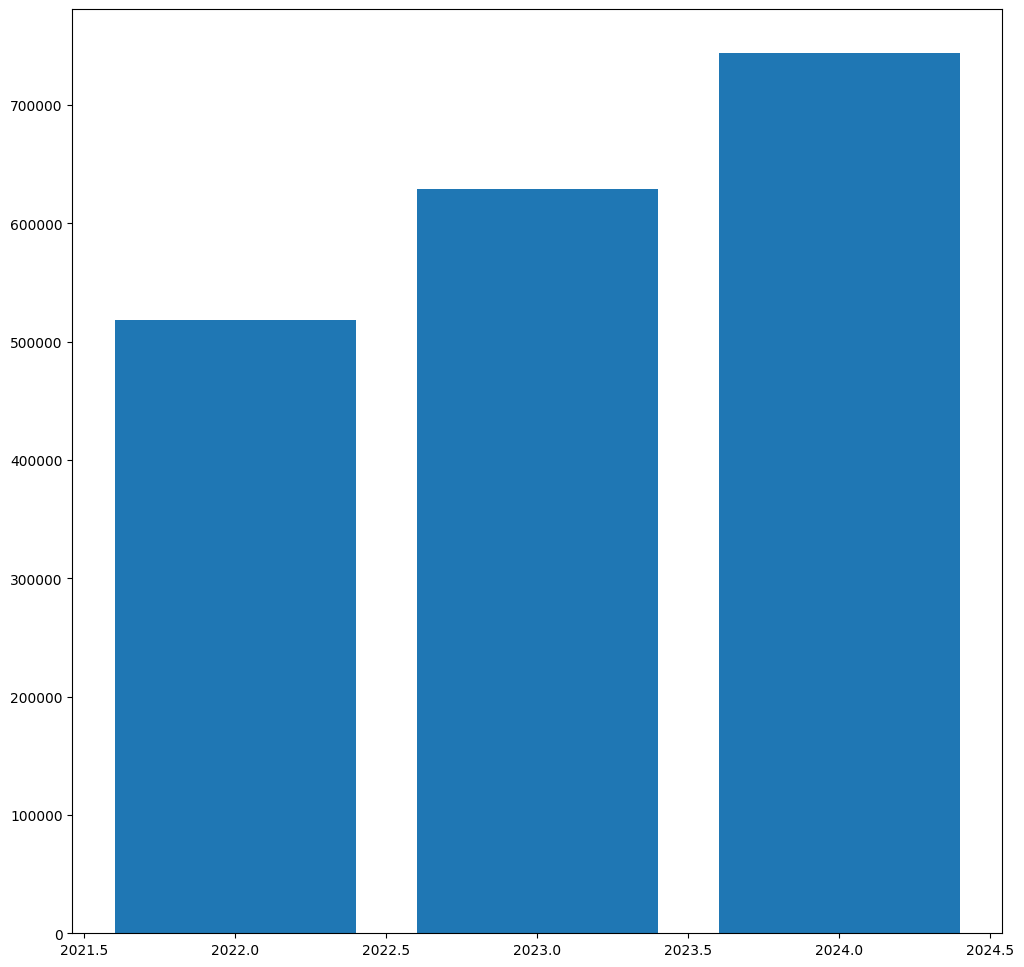

In [24]:
print(agg_data_2022['month'].unique())
print(agg_data_2023['month'].unique())
print(agg_data_2024['month'].unique())

plt.figure(figsize=(12,12))

agg_show = agg_data[agg_data['month'] == 8]

plt.bar(
    agg_show['year'],
    agg_show['total_footfall']
)

plt.show()

In [8]:
validate_data(lbhf_footfall_data,show_counts=True)

#########################################################################################################################################################################################
DataFrame: __


,hex_id,count_date,day,time_indicator,resident,visitor,worker,loyalty_percentage,dwell_time,year,month,DoY,total_footfall
5444971,11211233,2022-05-01,Sun,03-06,484,0,0,2.30,144.14,2022,5,121,484
5444972,11211233,2022-05-01,Sun,06-09,537,0,0,1.45,128.23,2022,5,121,537
5444973,11211233,2022-05-01,Sun,09-12,601,0,0,3.50,100.62,2022,5,121,601
5444974,11211233,2022-05-01,Sun,12-15,613,123,14,3.10,100.44,2022,5,121,750
5444975,11211233,2022-05-01,Sun,15-18,623,99,13,2.94,78.63,2022,5,121,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104471796,11381218,2024-10-13,Sun,09-12,31,0,0,13.04,98.52,2024,10,287,31
104471797,11381218,2024-10-13,Sun,12-15,24,0,0,16.78,89.17,2024,10,287,24
104471798,11381218,2024-10-13,Sun,15-18,33,0,0,10.50,87.14,2024,10,287,33
104471799,11381218,2024-10-13,Sun,18-21,17,0,0,18.02,94.02,2024,10,287,17


Unique values per field:


,Field Name,No. of Unique Values
0,hex_id,164
1,count_date,895
2,day,7
3,time_indicator,8
4,resident,2619
5,visitor,8836
6,worker,4376
7,loyalty_percentage,4449
8,dwell_time,14578
9,year,3



Number of duplicate rows:
0 

<class 'pandas.core.frame.DataFrame'>
Index: 1163956 entries, 5444971 to 104471800
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   hex_id              1163956 non-null  int64         
 1   count_date          1163956 non-null  datetime64[ns]
 2   day                 1163956 non-null  category      
 3   time_indicator      1163956 non-null  category      
 4   resident            1163956 non-null  uint16        
 5   visitor             1163956 non-null  uint16        
 6   worker              1163956 non-null  uint16        
 7   loyalty_percentage  1064663 non-null  float64       
 8   dwell_time          1163366 non-null  float64       
 9   year                1163956 non-null  int32         
 10  month               1163956 non-null  int32         
 11  DoY                 1163956 non-null  int32         
 12  total_footfall      1163956 non-null

None


Summary statistics:


,hex_id,count_date,resident,visitor,worker,loyalty_percentage,dwell_time,year,month,DoY,total_footfall
count,1.163956e+06,1163956,1.163956e+06,1.163956e+06,1.163956e+06,1.064663e+06,1.163366e+06,1.163956e+06,1.163956e+06,1.163956e+06,1.163956e+06
mean,1.128263e+07,2023-07-25 05:30:11.882924032,6.781082e+02,3.951580e+02,1.703834e+02,6.542288e+00,9.362882e+01,2.023053e+03,6.645155e+00,1.867243e+02,1.243650e+03
min,1.121123e+07,2022-05-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.032000e+01,2.022000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.125123e+07,2022-12-14 00:00:00,3.120000e+02,1.190000e+02,3.800000e+01,2.660000e+00,7.476000e+01,2.022000e+03,4.000000e+00,1.120000e+02,5.950000e+02
50%,1.128122e+07,2023-07-25 00:00:00,6.610000e+02,2.310000e+02,7.900000e+01,5.300000e+00,9.040000e+01,2.023000e+03,7.000000e+00,1.900000e+02,1.060000e+03
75%,1.131123e+07,2024-03-06 00:00:00,9.760000e+02,4.160000e+02,1.730000e+02,8.880000e+00,1.120600e+02,2.024000e+03,9.000000e+00,2.650000e+02,1.565000e+03
max,1.138122e+07,2024-10-13 00:00:00,3.073000e+03,5.096000e+04,5.533000e+03,7.500000e+01,1.874700e+02,2.024000e+03,1.200000e+01,3.650000e+02,5.480500e+04
std,4.280194e+04,NaN,4.562914e+02,9.438187e+02,3.181942e+02,5.523136e+00,2.566002e+01,7.685589e-01,3.212168e+00,9.802548e+01,1.360318e+03


End of data validation
#########################################################################################################################################################################################

